## 雷达仿真

通过FMCW雷达仿真代码，比较各类DOA算法性能。

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# 设计雷达系统参数
f0_,c_ = 77e9, 3e8 
waveL = c_ / f0_ # 波长

r_res, v_res = 0.3, 0.2

B = c_ / (2*r_res)      # 带宽
print(f"带宽B: {B * 1e-6} MHz")

N_chirp = 256
T_chirp = waveL / (2*v_res*N_chirp)
T_frame = N_chirp * T_chirp
maxV = waveL / (4*T_chirp)  # Chirp时长

print(f"T_chirp: {T_chirp*1e3}, T_frame: {T_frame*1e3}, maxV: {maxV}")

ADC_smp = 256
fs = ADC_smp / T_chirp
s_ = B / T_chirp
maxR_ = c_ * fs * 0.5 / (2 * s_) 

print(f"fs: {fs * 1e-6}MHz, maxR_: {maxR_}m")

RX_N = 12
d = 0.5 * waveL 
D = np.arange(RX_N) * d  # 接收天线阵列

R_FFT_N, V_FFT_N = 256, 256 #距离FFT和速度FFT

带宽B: 500.0 MHz
T_chirp: 0.03804788961038961, T_frame: 9.74025974025974, maxV: 25.6
fs: 6.7283626666666665MHz, maxR_: 38.4m


In [66]:
# 构造目标
R = np.array([10, 10, 20, 20])  # 目标距离
v = np.array([12, -10, 5, 8])  # 目标速度
theta = np.array([20, 25, 10, 13]) / 180.0 * np.pi   # 目标角度
tar_num = R.shape[0]

In [67]:
## 回波信号仿真（pyton速度太慢，弃用！）
# rx_sig1 = np.zeros((len(R), RX_N, N_chirp, ADC_smp), dtype=complex)
# # 回波信号仿真
# for m in range(len(R)):
#     for k in range(N_chirp):
#         for L in range(RX_N):
#             for n in range(ADC_smp):
#                 rx_sig1[m, L, k, n] = np.exp(1j * 2 * np.pi * (
#                     (0.5 * B / T_chirp * 2 * ((2 * (R[m] + v[m] * k * T_chirp)) / c_ - D[L] * np.sin(theta[m]) / c_)) * T_chirp / ADC_smp * n +
#                     f0_ * (2 * (R[m] + v[m] * k * T_chirp) / c_ - D[L] * np.sin(theta[m]) / c_)
#                 ))
                
# data_in = np.sum(rx_sig1, axis=0)

In [68]:
rx_sig1 = np.zeros((len(R), RX_N, N_chirp, ADC_smp), dtype=complex)
chirp_idx = np.linspace(1, N_chirp, N_chirp).reshape([-1, 1])
# print(chirp_idx.shape)
# 回波信号仿真
for m in range(tar_num):
    for L in range(RX_N):    
        # for k in range(N_chirp):        
        R_k = R[m] + v[m] * chirp_idx * T_chirp
        sin_component = D[L] * np.sin(theta[m]) / c_
        common_factor = 0.5 * B / T_chirp * 2 / c_
        constant_phase = f0_ * (2 * R_k / c_ - sin_component)

        # 计算每个 n 的增量
        incremental_phase = common_factor * (2 * R_k - sin_component * T_chirp) / ADC_smp * T_chirp

        # 使用 NumPy 创建 n 的数组
        n_array = np.arange(ADC_smp)

        # 计算所有 n 的相位
        phases = 1j * 2 * np.pi * (incremental_phase * n_array + constant_phase)

        # 计算复指数
        rx_sig1[m, L, :, :] = np.exp(phases)
                
data_in = np.sum(rx_sig1, axis=0)

In [69]:
# # 选择一个接收器和一个Chirp来可视化
# L = 0
# k = 0
# plt.figure(figsize=(10,4))
# plt.plot(np.real(data_in[L, k, :]), label='Real Part')
# # plt.plot(np.imag(data_in[L, k, :]), label='Imaginary Part')
# plt.title('Received Signal at Receiver {} and Chirp {}'.format(L, k))
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)
# plt.show()

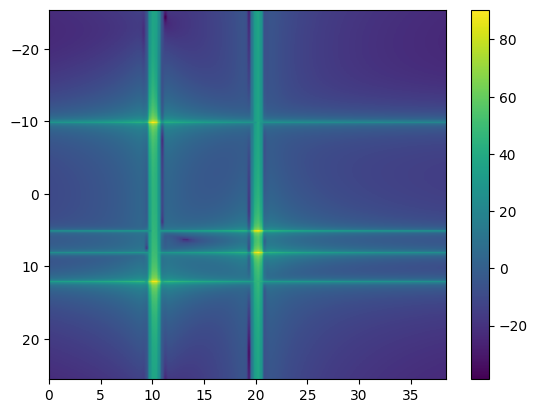

In [70]:
from scipy.signal import hamming, get_window

# 生成窗函数
window = hamming(R_FFT_N)  # 汉明窗

data_cube = np.zeros([RX_N, N_chirp, R_FFT_N], dtype=complex)

# range FFT
for L in range(RX_N):
    for i in range(N_chirp):
        data_cube[L, i, :] = np.fft.fft(data_in[L, i, :] * window, R_FFT_N)
        # plt.plot(np.abs(data_cube[L, i, :]))

# 速度维FFT
for L in range(RX_N):
    for i in range(R_FFT_N):
         data_cube[L, :, i] = np.fft.fftshift(np.fft.fft(data_cube[L, :, i], N_chirp))

# # 距离维FFT
# data_cube = np.fft.fft(data_in, n=R_FFT_N, axis=2)
# # plt.figure()
# # plt.plot(np.abs(data_cube[0,0,0:30]),'-o')

# # 速度维FFT
# data_cube = np.fft.fft(data_cube, n=V_FFT_N, axis=1)
# data_cube = np.fft.fftshift(data_cube, axes=1)  # FFT shift for alignment

# 计算距离和速度坐标轴
rangeBin =  (c_ * T_chirp / (2*B)) * (fs / R_FFT_N)
range_axis = np.linspace(0, int(R_FFT_N/2)) * rangeBin 
velBin = (c_ / f0_ * 0.5) / (T_chirp * V_FFT_N)  
velocity_axis = np.linspace(-V_FFT_N / 2 + 1, V_FFT_N / 2, V_FFT_N) * velBin

plt.figure()
plt.imshow((20 * np.log10(np.abs(data_cube[L, :, 0:int(R_FFT_N/2)]))), aspect='auto', extent=(range_axis[0], range_axis[-1], velocity_axis[-1], velocity_axis[0]))
plt.colorbar()

In [71]:
import numpy as np


def os_cfar_2d(data, guard_cells, noise_cells, gate, threshold_scale):
    """
    2D OS-CFAR detector.
    
    参数:
    - data: 输入的二维数组（雷达数据）
    - guard_cells: 保护单元的大小（元组形式，(行数, 列数)）
    - noise_cells: 噪声单元的大小（元组形式，(行数, 列数)）
    - threshold_scale: 用于调整阈值的缩放因子
    
    返回:
    - detections: 检测到的目标列表，每个元素为 (行, 列)
    """
    num_rows, num_cols = data.shape
    guard_rows, guard_cols = guard_cells
    noise_rows, noise_cols = noise_cells
    
    detections = []

    for row in range(num_rows):
        for col in range(num_cols):
            # 确定噪声和保护区域的边界
            row_start = max(row - guard_rows - noise_rows, 0)
            row_end = min(row + guard_rows + noise_rows + 1, num_rows)
            col_start = max(col - guard_cols - noise_cols, 0)
            col_end = min(col + guard_cols + noise_cols + 1, num_cols)
            
            # 保护区域边界
            guard_row_start = max(row - guard_rows, 0)
            guard_row_end = min(row + guard_rows + 1, num_rows)
            guard_col_start = max(col - guard_cols, 0)
            guard_col_end = min(col + guard_cols + 1, num_cols)
            
            # 提取噪声单元
            noise_patch = data[row_start:row_end, col_start:col_end]
            guard_patch = data[guard_row_start:guard_row_end, guard_col_start:guard_col_end]
            noise_patch = np.ma.array(noise_patch, mask=False)
            noise_patch.mask[guard_row_start-row_start:guard_row_end-row_start, guard_col_start-col_start:guard_col_end-col_start] = True
            
            # 计算阈值
            noise_level = np.mean(noise_patch.compressed())  # 使用压缩以去除被掩码的元素
            threshold = noise_level * threshold_scale
            
            # 检测
            if  data[row, col] > gate and data[row, col] > threshold and data[row, col] == np.max(guard_patch):
                detections.append((row, col))
    
    return detections

下面是各种结算DOA的算法函数

In [72]:
from scipy import linalg
import numpy as np

# using FFT
def doa_FFT(received_signals, fft_n):
    fft_data = np.abs(np.fft.fftshift(np.fft.fft(received_signals, fft_n))) # 角度维FFT
    fft_spectrum = 10 * np.log10(fft_data / np.max(fft_data))
    search_angles = np.linspace(-45, 45, fft_n)
    return search_angles, fft_spectrum 


# using MUSIC
def music_algorithm(received_signals, num_sources, num_antennas, n):
    """ MUSIC算法实现 """
    # 计算协方差矩阵
    R = received_signals @ received_signals.conj().T
    R /= np.trace(R)
    
    # 特征值分解
    eigenvalues, eigenvectors = np.linalg.eigh(R)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 噪声子空间
    noise_subspace = eigenvectors[:, num_sources:]
    
    # 搜索角度
    search_angles = np.linspace(-45, 45, n)
    search_rad = np.deg2rad(search_angles)
    music_spectrum = np.zeros(search_angles.shape)
    
    for i, angle in enumerate(search_rad):
        steering_vector = np.exp(2j * np.pi * 0.5 * np.arange(num_antennas) * np.sin(angle))
        music_spectrum[i] = 1 / np.abs(steering_vector.conj().T @ noise_subspace @ noise_subspace.conj().T @ steering_vector)
    
    music_spectrum = 10 * np.log10(music_spectrum / np.max(music_spectrum))  # 转换为dB
    return search_angles, music_spectrum


def doa_capon(received_signals, spacing=0.5, n=90):
    """
    Capon (MVDR) beamforming for a uniform linear array (ULA)

    :param numpy.2darray covmat:
        Sensor covariance matrix, specified as a complex-valued, positive-
        definite M-by-M matrix. The quantity M is the number of elements
        in the ULA array
    :param float spacing:
        Distance (wavelength) between array elements. ``default 0.5``
    :param numpy.1darray scanangles:
        Broadside search angles, specified as a real-valued vector in degrees.
        Angles must lie in the range [-90°,90°] and must be in increasing
        order. ``default [-90°,90°] ``

    :return: spectrum in dB
    :rtype: numpy.1darray
    """
    # 计算协方差矩阵
    R = received_signals @ received_signals.conj().T
    R /= np.trace(R)
    
    n_array = np.shape(R)[0]
    array = np.linspace(0, (n_array - 1) * spacing, n_array)
    scanangles = np.linspace(-45, 45, n)

    array_grid, angle_grid = np.meshgrid(array, np.radians(scanangles), indexing="ij")
    steering_vect = np.exp(1j * 2 * np.pi * array_grid * np.sin(angle_grid)) / np.sqrt(n_array)

    R = R + np.eye(n_array) * 0.000000001
    inv_covmat = linalg.pinv(R)

    ps = np.zeros(scanangles.shape)
    for idx, _ in enumerate(scanangles):
        s_vect = steering_vect[:, idx]

        weight = inv_covmat @ s_vect / (s_vect.T.conj() @ inv_covmat @ s_vect)
        ps[idx] = np.abs(weight.T.conj() @ R @ weight)

    return 10 * np.log10(ps)

def doa_esprit(received_signals, nsig, spacing=0.5):
    """
    Estimate arrival directions of signals using ESPRIT for a uniform linear
    array (ULA)

    :param numpy.2darray covmat:
        Sensor covariance matrix, specified as a complex-valued, positive-
        definite M-by-M matrix. The quantity M is the number of elements
        in the ULA array
    :param int nsig:
        Number of arriving signals, specified as a positive integer. The
        number of signals must be smaller than the number of elements in
        the ULA array
    :param float spacing:
        Distance (wavelength) between array elements. ``default 0.5``

    :return: doa angles in degrees
    :rtype: list
    """
    # 计算协方差矩阵
    R = received_signals @ received_signals.conj().T
    R /= np.trace(R)
    
    _, eig_vects = linalg.eigh(R)
    signal_subspace = eig_vects[:, -nsig:]

    # the original array is divided into two subarrays
    # [0,1,...,N-2] and [1,2,...,N-1]
    phi = linalg.pinv(signal_subspace[0:-1]) @ signal_subspace[1:]
    eigs = linalg.eigvals(phi)
    return np.degrees(np.arcsin(np.angle(eigs) / np.pi / (spacing / 0.5)))

def doa_root_music(received_signals, nsig, spacing=0.5):
    """
    Estimate arrival directions of signals using root-MUSIC for a uniform
    linear array (ULA)

    :param numpy.2darray covmat:
        Sensor covariance matrix, specified as a complex-valued, positive-
        definite M-by-M matrix. The quantity M is the number of elements
        in the ULA array
    :param int nsig:
        Number of arriving signals, specified as a positive integer. The
        number of signals must be smaller than the number of elements in
        the ULA array
    :param float spacing:
        Distance (wavelength) between array elements. ``default 0.5``

    :return: doa angles in degrees
    :rtype: list
    """
    # 计算协方差矩阵
    R = received_signals @ received_signals.conj().T
    R /= np.trace(R)
    n_covmat = np.shape(R)[0]

    _, eig_vects = linalg.eigh(R)
    noise_subspace = eig_vects[:, :-nsig]

    # Compute the coefficients for the polynomial.
    noise_mat = noise_subspace @ noise_subspace.T.conj()
    coeff = np.zeros((n_covmat - 1,), dtype=np.complex_)
    for i in range(1, n_covmat):
        coeff[i - 1] = np.trace(noise_mat, i)
    coeff = np.hstack((coeff[::-1], np.trace(noise_mat), coeff.conj()))

    roots = np.roots(coeff)

    # Find k points inside the unit circle that are also closest to the unit
    # circle.
    mask = np.abs(roots) <= 1
    # On the unit circle. Need to find the closest point and remove it.
    for _, i in enumerate(np.where(np.abs(roots) == 1)[0]):
        mask_idx = np.argsort(np.abs(roots - roots[i]))[1]
        mask[mask_idx] = False

    roots = roots[mask]
    sorted_indices = np.argsort(1.0 - np.abs(roots))
    sin_vals = np.angle(roots[sorted_indices[:nsig]]) / (2 * np.pi * spacing)

    return np.degrees(np.arcsin(sin_vals))

检测到的目标位置: [(78, 33), (153, 67), (168, 67), (188, 34)]
[-25.00411311 -19.99728833] [-25.00399603 -19.99532655]


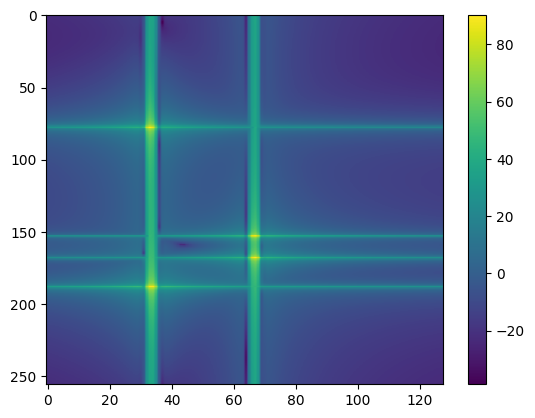

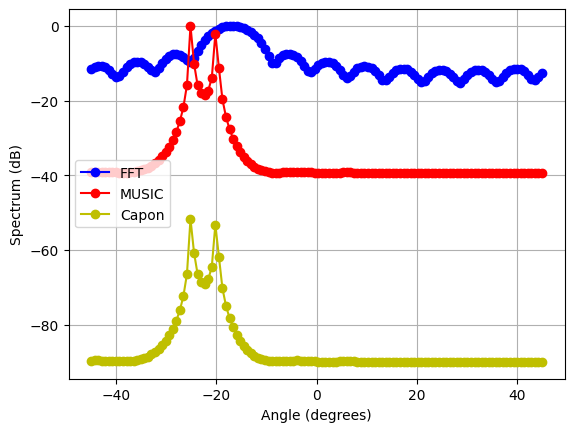

[ -9.86676377 -12.93324019] [-12.84381981  -9.80542825]


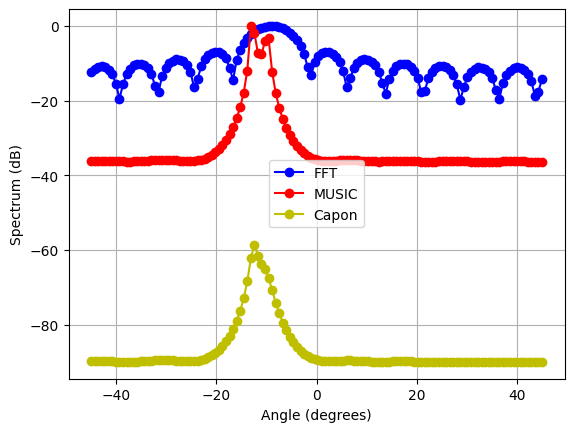

[ -9.86676377 -12.93324019] [-12.84381981  -9.80542825]


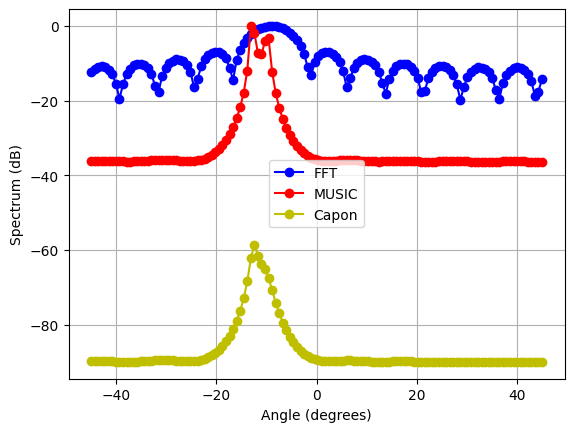

[-24.99342523 -20.00518002] [-24.99365809 -20.00848481]


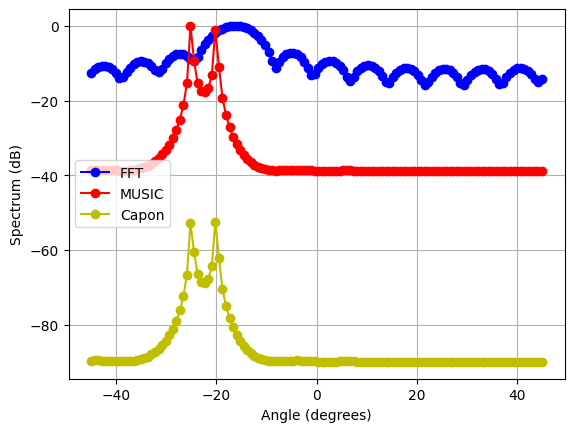

In [74]:
plt.figure()
plt.imshow((20 * np.log10(np.abs(data_cube[L, :, 0:int(R_FFT_N/2)]))), aspect='auto')
plt.colorbar()

# DOA估计
# 在进行DOA估计之前，需要先提取目标RangeBin对应的不同接收天线下的数据
data = 20 * np.log10(np.abs(data_cube[0, :, 0:int(R_FFT_N/2)]))

# plt.figure()
# plt.imshow(data)

guard_cells = (2, 2)
noise_cells = (4, 4)
gate, threshold_scale = 60, 2

# 执行简单的CFAR检测
detections = os_cfar_2d(data, guard_cells, noise_cells, gate, threshold_scale)
print("检测到的目标位置:", detections)

angleBin_num = 128
for idx, det in enumerate(detections):
    # 获取距离维索引
    rangeBin = det[1] 
    
    tmpN = 2
    tar1_rx_data = data_cube[:, 0:tmpN, rangeBin] 
    # print(tar1_rx_data.shape)
    
    # plt.figure()
    # for ii in range(tmpN):
    #     plt.subplot(tmpN,1,ii+1)
    #     plt.plot(np.real(tar1_rx_data[:, ii]), 'r')
    #     plt.plot(np.imag(tar1_rx_data[:, ii]),'b')
        
    search_angles, fft_spectrum = doa_FFT(tar1_rx_data[:, 0], angleBin_num)     # using FFT 
    search_angles, music_spectrum = music_algorithm(tar1_rx_data.reshape([RX_N, -1]), 2, RX_N, angleBin_num)     # using FFT 
    capon_specturm = doa_capon(tar1_rx_data.reshape([RX_N, -1]), n=angleBin_num)     # using Capon 
    
    # 直接求解的方法（不是空间扫描方法）
    ang1 = doa_esprit(tar1_rx_data.reshape([RX_N, -1]), 2)
    ang2 = doa_root_music(tar1_rx_data.reshape([RX_N, -1]), 2)
    print(ang1, ang2)

    # 绘制MUSIC谱
    plt.figure()
    plt.plot(search_angles, fft_spectrum, '-bo')
    plt.plot(search_angles, music_spectrum, '-ro')
    plt.plot(search_angles, capon_specturm, '-yo')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Spectrum (dB)')
    plt.legend(['FFT', 'MUSIC', 'Capon'])
    plt.grid(True)
    plt.show()

## MUSIC

MUSIC（Multiple Signal Classification）算法是一种广泛用于信号处理领域的谱估计方法，特别是在阵列信号处理（如方向估计或源定位）中非常有效。MUSIC算法基于信号子空间和噪声子空间的概念，利用接收到的信号中的空间特性来估计波达方向（Direction of Arrival, DOA）或源位置。

### MUSIC算法的基本原理包括以下几个关键步骤：

#### 1. 数据模型
假设一个由$P$个窄带远场信号源构成的信号被一个包含$M$个传感器的阵列接收。信号模型可以表示为：
$\mathbf{X}(t) = \mathbf{A}(\mathbf{s}) \mathbf{s}(t) + \mathbf{n}(t)$
其中，$\mathbf{X}(t)$是接收信号矢量，$\mathbf{A}(\mathbf{s})$是由信号源的方向向量构成的阵列流形矩阵，$\mathbf{s}(t)$是源信号矢量，$\mathbf{n}(t)$是噪声矢量。

#### 2. 协方差矩阵的估计
计算接收信号的协方差矩阵：
$\mathbf{R} = \frac{1}{N} \sum_{t=1}^N \mathbf{X}(t) \mathbf{X}^H(t)$
其中，$N$是样本数，$H$表示共轭转置。

#### 3. 特征分解
对协方差矩阵$\mathbf{R}$进行特征分解，得到其特征值和特征向量。将特征向量按对应特征值的大小排序，最大的$P$个特征值对应的特征向量构成信号子空间，其余的特征向量构成噪声子空间。

#### 4. 空间谱函数的构建
MUSIC算法的核心在于构建一个空间谱函数，该函数在源存在的方向上具有峰值。空间谱函数定义为：
$P(\theta) = \frac{1}{\mathbf{a}^H(\theta) \mathbf{E}_n \mathbf{E}_n^H \mathbf{a}(\theta)}$
其中，$\mathbf{a}(\theta)$是给定方向$\theta$下的阵列流形向量，$\mathbf{E}_n$是噪声子空间的基底。

#### 5. 方向估计
通过搜索空间谱函数$P(\theta)$的峰值来估计信号源的方向。峰值的位置对应于信号源的方向。

### 特点
- MUSIC算法提供了非常高的分辨率，能够区分相距非常近的信号源。
- 它是一种基于数据的方法，不需要关于信号或噪声的先验知识。
- 适用于信号源数少于传感器数的情况。

### 限制
- 当信号源数目接近或超过传感器数目时，性能会下降。
- 对模型中的假设（如信号和噪声的统计独立性）敏感。

MUSIC算法是阵列信号处理中一个非常强大的工具，广泛应用于雷达、声纳、无线通信等领域。


## MUSIC Root_MUSIC

### MUSIC 算法

MUSIC 算法是一种基于子空间的方法，它利用信号子空间和噪声子空间之间的正交性。MUSIC 算法的主要步骤包括：

1. **数据协方差矩阵的计算**：从接收到的信号中计算数据的协方差矩阵。
2. **特征分解**：对协方差矩阵进行特征分解，分离出信号子空间和噪声子空间。
3. **空间谱函数的构建**：使用信号子空间和噪声子空间的正交性来构建空间谱函数。该函数在信号源存在的方向上有峰值。
4. **峰值搜索**：搜索空间谱函数的峰值，这些峰值对应于到达角的估计。

### ROOT-MUSIC 算法

ROOT-MUSIC 算法是 MUSIC 算法的一个变体，它**直接通过求解多项式的根来找到信号的DOA，从而避免了对空间谱函数进行搜索**。其主要步骤如下：

1. **数据协方差矩阵的计算**：与 MUSIC 算法相同。
2. **特征分解**：与 MUSIC 算法相同。
3. **多项式构建**：使用从信号子空间得到的信息构建一个多项式。
4. **求解多项式的根**：多项式的根直接给出信号的到达角度。

### 主要区别

- **计算复杂度**：ROOT-MUSIC 通常比 MUSIC 算法具有更低的计算复杂度，因为它避免了对整个角度范围的搜索。它直接通过求解多项式的根来确定到达角，这在理论上更加高效。
- **实现复杂度**：尽管 ROOT-MUSIC 在计算上可能更高效，但它在实现上可能更复杂，特别是在多项式的构建和根的求解方面。
- **性能**：在低信噪比或者当信号源数量接近阵列元素数量时，MUSIC 算法可能表现得更好，因为 ROOT-MUSIC 在这些情况下的性能可能会下降。
